# Resampled

399 rows with missing values
399 rows with missing gini coef
Target distribution:
best_method_weighted_mae_0
N3          3796
Bayesian    1672
PD          1547
Conrad      1176
EM           845
Nahmias      824
Agrawal      468
Baseline     294
N1            47
N2            16
Name: count, dtype: int64

Training set distribution:
best_method_weighted_mae_0
N3          3054
Bayesian    1310
PD          1258
Conrad       916
EM           682
Nahmias      645
Agrawal      390
Baseline     240
N1            42
N2            11
Name: count, dtype: int64

After resampling:
best_method_weighted_mae_0
Agrawal     2000
Baseline    2000
Bayesian    2000
Conrad      2000
EM          2000
N1          2000
N2          2000
N3          2000
Nahmias     2000
PD          2000
Name: count, dtype: int64

Classification Report:
              precision    recall  f1-score   support

     Agrawal       0.21      0.64      0.32        78
    Baseline       0.17      0.74      0.28        54
    Bayesian   

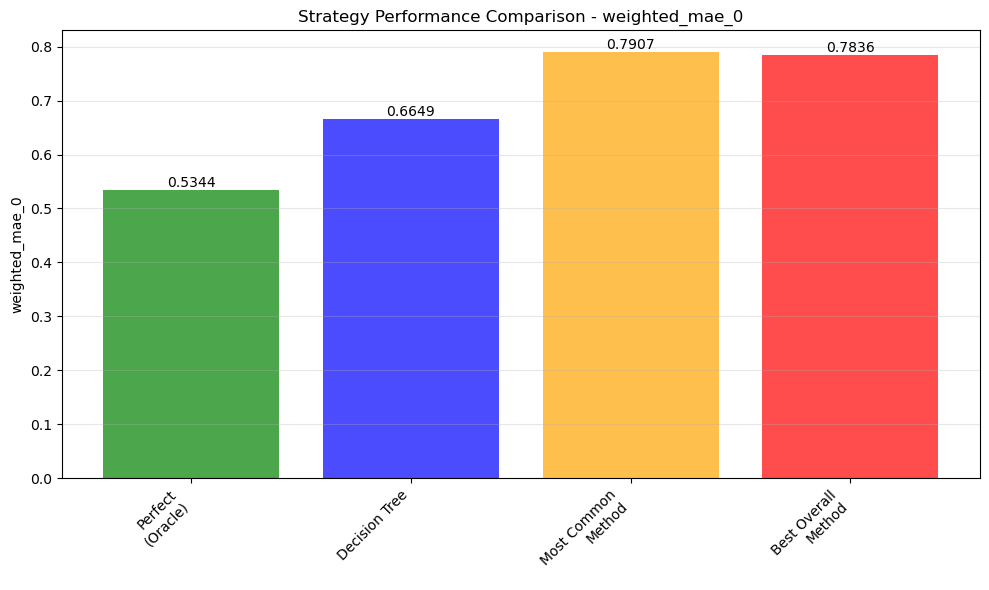

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, matthews_corrcoef, accuracy_score, f1_score
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter

def evaluate_strategy_performance(df, X_test, y_test, y_pred, methods, metric_name="weighted_mae_0", optimization_direction="minimize"):
    """
    Evaluate different strategy performances for POS method selection.
    
    Parameters:
    - df: Original dataframe with all method performance metrics
    - X_test: Test features
    - y_test: True best methods for test set
    - y_pred: Predicted methods from decision tree
    - methods: List of all available methods
    - metric_name: Name of the metric to evaluate (default: "weighted_mae_0")
    - optimization_direction: "minimize" or "maximize" for the metric
    
    Returns:
    - Dictionary with strategy performance results
    """
    
    # CREATE METHOD MAPPING HERE - this fixes the Bayesian vs Bayesian_POS issue
    method_mapping = {
        'Bayesian': 'Bayesian_POS',  # Add this line to map Bayesian -> Bayesian_POS
        # Add other mappings if needed, e.g.:
        # 'SomeOtherName': 'ActualColumnName'
    }
    
    def map_method_name(method_name):
        """Map method names from best_method column to actual column names."""
        return method_mapping.get(method_name, method_name)
    
    # Get the test set indices to align with original dataframe
    test_indices = X_test.index
    
    # 1. Perfect Strategy (Oracle): Always pick the best method
    perfect_metric_values = []
    for idx in test_indices:
        best_method = df.loc[idx, f'best_method_{metric_name}']
        # APPLY MAPPING HERE
        mapped_method = map_method_name(best_method)
        best_metric_value = df.loc[idx, f'{mapped_method}_{metric_name}']
        perfect_metric_values.append(best_metric_value)
    perfect_avg_metric = np.mean(perfect_metric_values)
    
    # 2. Decision Tree Strategy: Use classifier predictions
    dt_metric_values = []
    for i, idx in enumerate(test_indices):
        predicted_method = y_pred[i]
        # APPLY MAPPING HERE
        mapped_method = map_method_name(predicted_method)
        predicted_metric_value = df.loc[idx, f'{mapped_method}_{metric_name}']
        dt_metric_values.append(predicted_metric_value)
    dt_avg_metric = np.mean(dt_metric_values)
    
    # 3. Most Common Method Strategy (from training set)
    y_train = df.loc[~df.index.isin(test_indices), f'best_method_{metric_name}']
    most_common_method = y_train.mode()[0]  # Use training set to determine most common
    # APPLY MAPPING HERE
    mapped_most_common = map_method_name(most_common_method)
    common_metric_values = []
    for idx in test_indices:
        common_metric_value = df.loc[idx, f'{mapped_most_common}_{metric_name}']
        common_metric_values.append(common_metric_value)
    common_avg_metric = np.mean(common_metric_values)
    
    # 4. Best Overall Method Strategy (best average metric across all data)
    method_avg_metrics = {}
    for method in methods:
        method_avg_metrics[method] = df[f'{method}_{metric_name}'].mean()
    
    if optimization_direction == "minimize":
        best_overall_method = min(method_avg_metrics, key=method_avg_metrics.get)
    else:
        best_overall_method = max(method_avg_metrics, key=method_avg_metrics.get)
    
    best_overall_metric_values = []
    for idx in test_indices:
        best_overall_metric_value = df.loc[idx, f'{best_overall_method}_{metric_name}']
        best_overall_metric_values.append(best_overall_metric_value)
    best_overall_avg_metric = np.mean(best_overall_metric_values)
    
    # Calculate performance gaps relative to perfect strategy
    if optimization_direction == "minimize":
        dt_gap = ((dt_avg_metric - perfect_avg_metric) / perfect_avg_metric) * 100
        common_gap = ((common_avg_metric - perfect_avg_metric) / perfect_avg_metric) * 100
        best_overall_gap = ((best_overall_avg_metric - perfect_avg_metric) / perfect_avg_metric) * 100
    else:
        dt_gap = ((perfect_avg_metric - dt_avg_metric) / perfect_avg_metric) * 100
        common_gap = ((perfect_avg_metric - common_avg_metric) / perfect_avg_metric) * 100
        best_overall_gap = ((perfect_avg_metric - best_overall_avg_metric) / perfect_avg_metric) * 100
    
    results = {
        'metric_name': metric_name,
        'optimization_direction': optimization_direction,
        'perfect_strategy': {
            'avg_metric': perfect_avg_metric,
            'description': 'Oracle - always picks the truly best method'
        },
        'decision_tree_strategy': {
            'avg_metric': dt_avg_metric,
            'gap_from_perfect_pct': dt_gap,
            'description': 'Decision tree predictions'
        },
        'most_common_strategy': {
            'avg_metric': common_avg_metric,
            'gap_from_perfect_pct': common_gap,
            'method_used': most_common_method,
            'description': f'Always use most common method ({most_common_method})'
        },
        'best_overall_strategy': {
            'avg_metric': best_overall_avg_metric,
            'gap_from_perfect_pct': best_overall_gap,
            'method_used': best_overall_method,
            'description': f'Always use method with best overall average ({best_overall_method})'
        },
        'method_averages': method_avg_metrics,
        'test_set_size': len(test_indices)
    }
    
    return results

def print_strategy_comparison(results):
    """Print a formatted comparison of strategy performances."""
    
    metric_name = results['metric_name']
    direction = results['optimization_direction']
    
    print(f"\n{'='*60}")
    print(f"STRATEGY PERFORMANCE COMPARISON - {metric_name.upper()}")
    print(f"Optimization Direction: {direction.upper()}")
    print(f"Test Set Size: {results['test_set_size']}")
    print(f"{'='*60}")
    
    strategies = ['perfect_strategy', 'decision_tree_strategy', 'most_common_strategy', 'best_overall_strategy']
    
    for strategy in strategies:
        data = results[strategy]
        print(f"\n{data['description']}:")
        print(f"  Average {metric_name}: {data['avg_metric']:.4f}")
        
        if 'gap_from_perfect_pct' in data:
            gap = data['gap_from_perfect_pct']
            if direction == "minimize":
                print(f"  Performance gap: +{gap:.2f}% worse than perfect")
            else:
                print(f"  Performance gap: -{gap:.2f}% worse than perfect")
        
        if 'method_used' in data:
            print(f"  Method used: {data['method_used']}")
    
    print(f"\n{'='*60}")
    print("METHOD AVERAGES ACROSS ALL DATA:")
    print(f"{'='*60}")
    sorted_methods = sorted(results['method_averages'].items(), 
                          key=lambda x: x[1], 
                          reverse=(direction == "maximize"))
    
    for method, avg_score in sorted_methods:
        print(f"  {method}: {avg_score:.4f}")

def plot_strategy_comparison(results):
    """Create a visualization comparing strategy performances."""
    
    strategies = ['Perfect\n(Oracle)', 'Decision Tree', 'Most Common\nMethod', 'Best Overall\nMethod']
    values = [
        results['perfect_strategy']['avg_metric'],
        results['decision_tree_strategy']['avg_metric'],
        results['most_common_strategy']['avg_metric'],
        results['best_overall_strategy']['avg_metric']
    ]
    
    colors = ['green', 'blue', 'orange', 'red']
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(strategies, values, color=colors, alpha=0.7)
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{value:.4f}', ha='center', va='bottom')
    
    plt.title(f'Strategy Performance Comparison - {results["metric_name"]}')
    plt.ylabel(f'{results["metric_name"]}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.grid(axis='y', alpha=0.3)
    plt.show()

# Your existing code with modifications
def run_complete_evaluation():
    """Run the complete decision tree training and evaluation pipeline."""
    
    # Step 1: Set up data for DT
    feature_cols = ["KSR_Anteil","TSR_Anteil","KSR_TSR_Anteil","data_sparsity",
                    "laenge","stockout_rate","verkauf_variance","verkauf_mean","coefficient_of_variation","unique_quantities",
                    "variance_to_mean_ratio","verkauf_autocorr","adi","censored_rate","censored_n"]
    
    df = pd.read_csv('dt_inputs/Uncensoring_DT_Input.csv')
    df.drop(['Gesamtzeilen','KSR_Count','TSR_Count','KSR_TSR_Summe'], axis='columns', inplace=True)
    
    print(f"{df.isnull().any(axis=1).sum()} rows with missing values")
    print(f"{df[['Bayesian_POS_gini_coefficient', 'Agrawal_gini_coefficient']].isna().any(axis=1).sum()} rows with missing gini coef")
    
    methods = ['N1', 'N2', 'N3', 'EM', 'PD', 'Conrad', 'Nahmias', 'Bayesian_POS', 'Baseline', 'Agrawal']
    
    X = df[feature_cols]
    y = df['best_method_weighted_mae_0']
    
    print("Target distribution:")
    print(y.value_counts())
    
    # Step 2: Split into train and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    y_counts = Counter(y_train)
    print("\nTraining set distribution:")
    print(y_train.value_counts())
    
    # Step 3: Resample training set
    small_classes = [cls for cls, count in y_counts.items() if count < 6]
    majority_class = max(y_counts, key=y_counts.get)
    random_sampling_strategy = {cls: 6 for cls in small_classes}
    under_sampling_strategy = {majority_class: 2000}
    
    sampler = Pipeline(steps=[
        ('under', RandomUnderSampler(sampling_strategy=under_sampling_strategy, random_state=42)),
        ('random', RandomOverSampler(sampling_strategy=random_sampling_strategy, random_state=42)),
        ('smote', SMOTE(sampling_strategy='auto', random_state=42))
    ])
    
    X_train_resampled, y_train_resampled = sampler.fit_resample(X_train, y_train)
    print('\nAfter resampling:')
    print(y_train_resampled.value_counts())
    
    # Step 4: Train Decision Tree
    clf = DecisionTreeClassifier(random_state=42, max_depth=8, criterion='entropy', min_samples_leaf=1)
    clf.fit(X_train_resampled, y_train_resampled)
    
    # Step 5: Evaluate
    y_pred = clf.predict(X_test)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("Matthew's correlation coefficient:", matthews_corrcoef(y_test, y_pred))
    
    # Step 6: Strategy Performance Evaluation
    print("\n" + "="*80)
    print("STRATEGY PERFORMANCE EVALUATION")
    print("="*80)
    
    # Evaluate for weighted_mae_0 metric
    results = evaluate_strategy_performance(
        df=df, 
        X_test=X_test, 
        y_test=y_test, 
        y_pred=y_pred, 
        methods=methods,
        metric_name="weighted_mae_0",
        optimization_direction="minimize"
    )
    
    print_strategy_comparison(results)
    plot_strategy_comparison(results)
    
    return results, clf, X_test, y_test, y_pred

# Run the complete evaluation
if __name__ == "__main__":
    results, trained_model, X_test, y_test, y_pred = run_complete_evaluation()

# No Resampling

399 rows with missing values
399 rows with missing gini coef
Target distribution:
best_method_weighted_mae_0
N3          3796
Bayesian    1672
PD          1547
Conrad      1176
EM           845
Nahmias      824
Agrawal      468
Baseline     294
N1            47
N2            16
Name: count, dtype: int64

Training set distribution:
best_method_weighted_mae_0
N3          3054
Bayesian    1310
PD          1258
Conrad       916
EM           682
Nahmias      645
Agrawal      390
Baseline     240
N1            42
N2            11
Name: count, dtype: int64

Classification Report:
              precision    recall  f1-score   support

     Agrawal       0.14      0.19      0.16        78
    Baseline       0.16      0.19      0.17        54
    Bayesian       0.51      0.44      0.47       362
      Conrad       0.37      0.32      0.34       260
          EM       0.47      0.46      0.46       163
          N1       0.18      0.40      0.25         5
          N2       0.50      0.20      0.

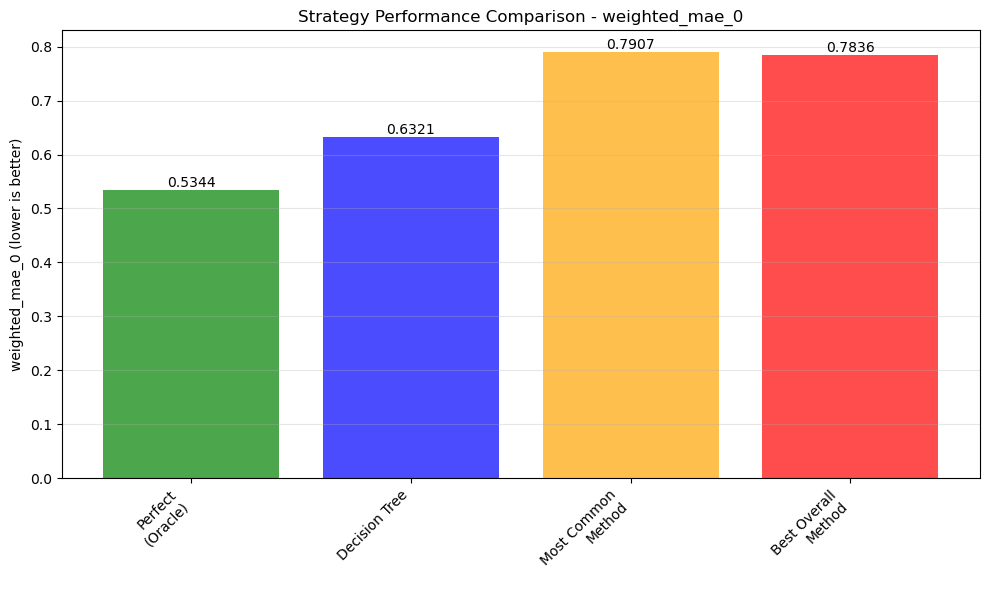

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, matthews_corrcoef
from collections import Counter

def evaluate_strategy_performance(df, X_test, y_test, y_pred, methods, metric_name="weighted_mae_0", optimization_direction="minimize"):
    """
    Evaluate different strategy performances for POS method selection.
    
    Parameters:
    - df: Original dataframe with all method performance metrics
    - X_test: Test features
    - y_test: True best methods for test set
    - y_pred: Predicted methods from decision tree
    - methods: List of all available methods
    - metric_name: Name of the metric to evaluate (default: "weighted_mae_0")
    - optimization_direction: "minimize" or "maximize" for the metric
    
    Returns:
    - Dictionary with strategy performance results
    """
    
    # CREATE METHOD MAPPING HERE - this fixes the Bayesian vs Bayesian_POS issue
    method_mapping = {
        'Bayesian': 'Bayesian_POS',  # Add this line to map Bayesian -> Bayesian_POS
        # Add other mappings if needed, e.g.:
        # 'SomeOtherName': 'ActualColumnName'
    }
    
    def map_method_name(method_name):
        """Map method names from best_method column to actual column names."""
        return method_mapping.get(method_name, method_name)
    
    # Get the test set indices to align with original dataframe
    test_indices = X_test.index
    
    # 1. Perfect Strategy (Oracle): Always pick the best method
    perfect_metric_values = []
    for idx in test_indices:
        best_method = df.loc[idx, f'best_method_{metric_name}']
        # APPLY MAPPING HERE
        mapped_method = map_method_name(best_method)
        best_metric_value = df.loc[idx, f'{mapped_method}_{metric_name}']
        perfect_metric_values.append(best_metric_value)
    perfect_avg_metric = np.mean(perfect_metric_values)
    
    # 2. Decision Tree Strategy: Use classifier predictions
    dt_metric_values = []
    for i, idx in enumerate(test_indices):
        predicted_method = y_pred[i]
        # APPLY MAPPING HERE
        mapped_method = map_method_name(predicted_method)
        predicted_metric_value = df.loc[idx, f'{mapped_method}_{metric_name}']
        dt_metric_values.append(predicted_metric_value)
    dt_avg_metric = np.mean(dt_metric_values)
    
    # 3. Most Common Method Strategy (from training set)
    y_train = df.loc[~df.index.isin(test_indices), f'best_method_{metric_name}']
    most_common_method = y_train.mode()[0]  # Use training set to determine most common
    # APPLY MAPPING HERE
    mapped_most_common = map_method_name(most_common_method)
    common_metric_values = []
    for idx in test_indices:
        common_metric_value = df.loc[idx, f'{mapped_most_common}_{metric_name}']
        common_metric_values.append(common_metric_value)
    common_avg_metric = np.mean(common_metric_values)
    
    # 4. Best Overall Method Strategy (best average metric across all data)
    method_avg_metrics = {}
    for method in methods:
        method_avg_metrics[method] = df[f'{method}_{metric_name}'].mean()
    
    if optimization_direction == "minimize":
        best_overall_method = min(method_avg_metrics, key=method_avg_metrics.get)
    else:
        best_overall_method = max(method_avg_metrics, key=method_avg_metrics.get)
    
    best_overall_metric_values = []
    for idx in test_indices:
        best_overall_metric_value = df.loc[idx, f'{best_overall_method}_{metric_name}']
        best_overall_metric_values.append(best_overall_metric_value)
    best_overall_avg_metric = np.mean(best_overall_metric_values)
    
    # Calculate performance gaps relative to perfect strategy
    if optimization_direction == "minimize":
        dt_gap = ((dt_avg_metric - perfect_avg_metric) / perfect_avg_metric) * 100
        common_gap = ((common_avg_metric - perfect_avg_metric) / perfect_avg_metric) * 100
        best_overall_gap = ((best_overall_avg_metric - perfect_avg_metric) / perfect_avg_metric) * 100
    else:
        dt_gap = ((perfect_avg_metric - dt_avg_metric) / perfect_avg_metric) * 100
        common_gap = ((perfect_avg_metric - common_avg_metric) / perfect_avg_metric) * 100
        best_overall_gap = ((perfect_avg_metric - best_overall_avg_metric) / perfect_avg_metric) * 100
    
    results = {
        'metric_name': metric_name,
        'optimization_direction': optimization_direction,
        'perfect_strategy': {
            'avg_metric': perfect_avg_metric,
            'description': 'Oracle - always picks the truly best method'
        },
        'decision_tree_strategy': {
            'avg_metric': dt_avg_metric,
            'gap_from_perfect_pct': dt_gap,
            'description': 'Decision tree predictions'
        },
        'most_common_strategy': {
            'avg_metric': common_avg_metric,
            'gap_from_perfect_pct': common_gap,
            'method_used': most_common_method,
            'description': f'Always use most common method ({most_common_method})'
        },
        'best_overall_strategy': {
            'avg_metric': best_overall_avg_metric,
            'gap_from_perfect_pct': best_overall_gap,
            'method_used': best_overall_method,
            'description': f'Always use method with best overall average ({best_overall_method})'
        },
        'method_averages': method_avg_metrics,
        'test_set_size': len(test_indices)
    }
    
    return results

def print_strategy_comparison(results):
    """Print a formatted comparison of strategy performances."""
    
    metric_name = results['metric_name']
    direction = results['optimization_direction']
    
    print(f"\n{'='*60}")
    print(f"STRATEGY PERFORMANCE COMPARISON - {metric_name.upper()}")
    print(f"Optimization Direction: {direction.upper()}")
    print(f"Test Set Size: {results['test_set_size']}")
    print(f"{'='*60}")
    
    strategies = ['perfect_strategy', 'decision_tree_strategy', 'most_common_strategy', 'best_overall_strategy']
    
    for strategy in strategies:
        data = results[strategy]
        print(f"\n{data['description']}:")
        print(f"  Average {metric_name}: {data['avg_metric']:.4f}")
        
        if 'gap_from_perfect_pct' in data:
            gap = data['gap_from_perfect_pct']
            if direction == "minimize":
                print(f"  Performance gap: +{gap:.2f}% worse than perfect")
            else:
                print(f"  Performance gap: -{gap:.2f}% worse than perfect")
        
        if 'method_used' in data:
            print(f"  Method used: {data['method_used']}")
    
    print(f"\n{'='*60}")
    print("METHOD AVERAGES ACROSS ALL DATA:")
    print(f"{'='*60}")
    sorted_methods = sorted(results['method_averages'].items(), 
                          key=lambda x: x[1], 
                          reverse=(direction == "maximize"))
    
    for method, avg_score in sorted_methods:
        print(f"  {method}: {avg_score:.4f}")

def plot_strategy_comparison(results):
    """Create a visualization comparing strategy performances."""
    
    strategies = ['Perfect\n(Oracle)', 'Decision Tree', 'Most Common\nMethod', 'Best Overall\nMethod']
    values = [
        results['perfect_strategy']['avg_metric'],
        results['decision_tree_strategy']['avg_metric'],
        results['most_common_strategy']['avg_metric'],
        results['best_overall_strategy']['avg_metric']
    ]
    
    colors = ['green', 'blue', 'orange', 'red']
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(strategies, values, color=colors, alpha=0.7)
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{value:.4f}', ha='center', va='bottom')
    
    plt.title(f'Strategy Performance Comparison - {results["metric_name"]}')
    plt.ylabel(f'{results["metric_name"]} ({"lower is better" if results["optimization_direction"] == "minimize" else "higher is better"})')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.grid(axis='y', alpha=0.3)
    plt.show()

# Your existing code with modifications
def run_complete_evaluation():
    """Run the complete decision tree training and evaluation pipeline."""
    
    # Step 1: Set up data for DT
    feature_cols = ["KSR_Anteil","TSR_Anteil","KSR_TSR_Anteil","data_sparsity",
                    "laenge","stockout_rate","verkauf_variance","verkauf_mean","coefficient_of_variation","unique_quantities",
                    "variance_to_mean_ratio","verkauf_autocorr","adi","censored_rate","censored_n"]
    
    df = pd.read_csv('dt_inputs/Uncensoring_DT_Input.csv')
    df.drop(['Gesamtzeilen','KSR_Count','TSR_Count','KSR_TSR_Summe'], axis='columns', inplace=True)
    
    print(f"{df.isnull().any(axis=1).sum()} rows with missing values")
    print(f"{df[['Bayesian_POS_gini_coefficient', 'Agrawal_gini_coefficient']].isna().any(axis=1).sum()} rows with missing gini coef")
    
    methods = ['N1', 'N2', 'N3', 'EM', 'PD', 'Conrad', 'Nahmias', 'Bayesian_POS', 'Baseline', 'Agrawal']
    
    X = df[feature_cols]
    y = df['best_method_weighted_mae_0']
    
    print("Target distribution:")
    print(y.value_counts())
    
    # Step 2: Split into train and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print("\nTraining set distribution:")
    print(y_train.value_counts())
    
    # Step 3: Train Decision Tree (no resampling)
    clf = DecisionTreeClassifier(random_state=42, max_depth=26, criterion='entropy', min_samples_leaf=1)
    clf.fit(X_train, y_train)
    
    # Step 4: Evaluate
    y_pred = clf.predict(X_test)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("Matthew's correlation coefficient:", matthews_corrcoef(y_test, y_pred))
    
    # Step 5: Strategy Performance Evaluation
    print("\n" + "="*80)
    print("STRATEGY PERFORMANCE EVALUATION")
    print("="*80)
    
    # Evaluate for weighted_mae_0 metric
    results = evaluate_strategy_performance(
        df=df, 
        X_test=X_test, 
        y_test=y_test, 
        y_pred=y_pred, 
        methods=methods,
        metric_name="weighted_mae_0",
        optimization_direction="minimize"
    )
    
    print_strategy_comparison(results)
    plot_strategy_comparison(results)
    
    return results, clf, X_test, y_test, y_pred

# Run the complete evaluation
if __name__ == "__main__":
    results, trained_model, X_test, y_test, y_pred = run_complete_evaluation()

# Inventory Tree

In [14]:
#Step 1: set up data for DT
df = pd.read_csv('dt_inputs/Sales_DT_Input.csv')
df.drop(['Gesamtzeilen','KSR_Count','TSR_Count','KSR_TSR_Summe'], axis='columns', inplace=True)
feature_cols = ["KSR_Anteil", "TSR_Anteil", "KSR_TSR_Anteil", "data_sparsity", "laenge",
                "stockout_rate", "verkauf_variance", "verkauf_mean", "coefficient_of_variation", "unique_quantities", 'variance_to_mean_ratio',
                "verkauf_autocorr", "adi", "censored_rate", "censored_n"]
df = df[df['laenge']>1] #so we have variance values for all points
#df = df[df['verkauf_mean']>=1]

print(f"{df.isna().any(axis=1).sum()} rows with missing values")
print(f"{df[feature_cols].isna().any(axis=1).sum()} rows with missing feature values")
print(f"{df[['Bayesian_POS_pinball_loss']].isna().any(axis=1).sum()} rows with missing Bayesian results")
print(f"{df[['Agrawal_pinball_loss']].isna().any(axis=1).sum()} rows with missing Agrawal results")
print(f"{df[['Bayesian_POS_pinball_loss', 'Agrawal_pinball_loss']].isna().any(axis=1).sum()} rows with missing Agrawal or Bayesian results")
#remaining ~1000 missing is because bayesian sometimes doesn't have beta fill rate

methods = ['N1', 'N2', 'N3', 'EM', 'PD', 'Conrad', 'Nahmias', 'Bayesian_POS', 'Baseline', 'Agrawal']

X = df[feature_cols]
y = df['best_method_pinball_loss']
print(y.value_counts())

#Step 2: Split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_counts = Counter(y_train)
print(y_train.value_counts())


#Step 3: resample training set

small_classes = [cls for cls, count in y_counts.items() if count < 6]
majority_class = max(y_counts, key=y_counts.get)
random_sampling_strategy = {cls: 6 for cls in small_classes} #for groups with < 6 items, use random sampling to increase size to 6
under_sampling_strategy = {'Baseline': 6000, 'Conrad': 6000} #use random undersampling on majority class to reduce
sampler = Pipeline(steps=[
    ('under', RandomUnderSampler(sampling_strategy=under_sampling_strategy, random_state=42)),
    ('random', RandomOverSampler(sampling_strategy=random_sampling_strategy, random_state=42)),
    ('smote', SMOTE(sampling_strategy='auto', random_state=42))
])

X_train_resampled, y_train_resampled = sampler.fit_resample(X_train, y_train)
print('after resampling:')
print(y_train_resampled.value_counts())

#Step 4: hyperparameter tuning

max_depth = [4]
min_samples_leaf = [1, 20, 40]
criterion = ['entropy', 'gini', 'log_loss']
for md in max_depth:
    for c in criterion:
        clf = DecisionTreeClassifier(random_state=42,max_depth=md, criterion=c, min_samples_leaf=1)
        clf.fit(X_train_resampled, y_train_resampled)
        #clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='macro')
        mcc = matthews_corrcoef(y_test, y_pred)

        print(f"max_depth={md}, criterion = {c}"
            f"-> Accuracy: {acc:.4f}, F1 (macro): {f1:.4f}, MCC: {mcc:.4f}")
        
#Step 5: Train DT on best hyperparameters

clf = DecisionTreeClassifier(random_state=42,max_depth=26, criterion='gini', min_samples_leaf=1)
clf.fit(X_train_resampled, y_train_resampled)
#clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print("matthew's correlation coef: ", matthews_corrcoef(y_test, y_pred))







7005 rows with missing values
0 rows with missing feature values
5797 rows with missing Bayesian results
5083 rows with missing Agrawal results
5797 rows with missing Agrawal or Bayesian results
best_method_pinball_loss
Baseline    9191
Conrad      8010
N1           850
Bayesian     809
Nahmias      790
Agrawal      363
EM           152
N2            68
PD             5
N3             2
Name: count, dtype: int64
best_method_pinball_loss
Baseline    7370
Conrad      6425
N1           683
Nahmias      625
Bayesian     624
Agrawal      284
EM           118
N2            57
PD             5
N3             1
Name: count, dtype: int64
after resampling:
best_method_pinball_loss
Agrawal     6000
Baseline    6000
Bayesian    6000
Conrad      6000
EM          6000
N1          6000
N2          6000
N3          6000
Nahmias     6000
PD          6000
Name: count, dtype: int64
max_depth=4, criterion = entropy-> Accuracy: 0.2458, F1 (macro): 0.1374, MCC: 0.1525
max_depth=4, criterion = gini-> Accurac

/opt/anaconda3/envs/tum/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/tum/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/tum/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/env

7005 rows with missing values
0 rows with missing feature values
5797 rows with missing Bayesian results
5083 rows with missing Agrawal results
5797 rows with missing Agrawal or Bayesian results
Target distribution:
best_method_pinball_loss
Baseline    9191
Conrad      8010
N1           850
Bayesian     809
Nahmias      790
Agrawal      363
EM           152
N2            68
PD             5
N3             2
Name: count, dtype: int64

Training set distribution:
best_method_pinball_loss
Baseline    7370
Conrad      6425
N1           683
Nahmias      625
Bayesian     624
Agrawal      284
EM           118
N2            57
PD             5
N3             1
Name: count, dtype: int64
After resampling:
best_method_pinball_loss
Agrawal     6000
Baseline    6000
Bayesian    6000
Conrad      6000
EM          6000
N1          6000
N2          6000
N3          6000
Nahmias     6000
PD          6000
Name: count, dtype: int64

Hyperparameter tuning:
max_depth=4, criterion = entropy -> Accuracy: 0.245

/opt/anaconda3/envs/tum/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/tum/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/tum/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/env

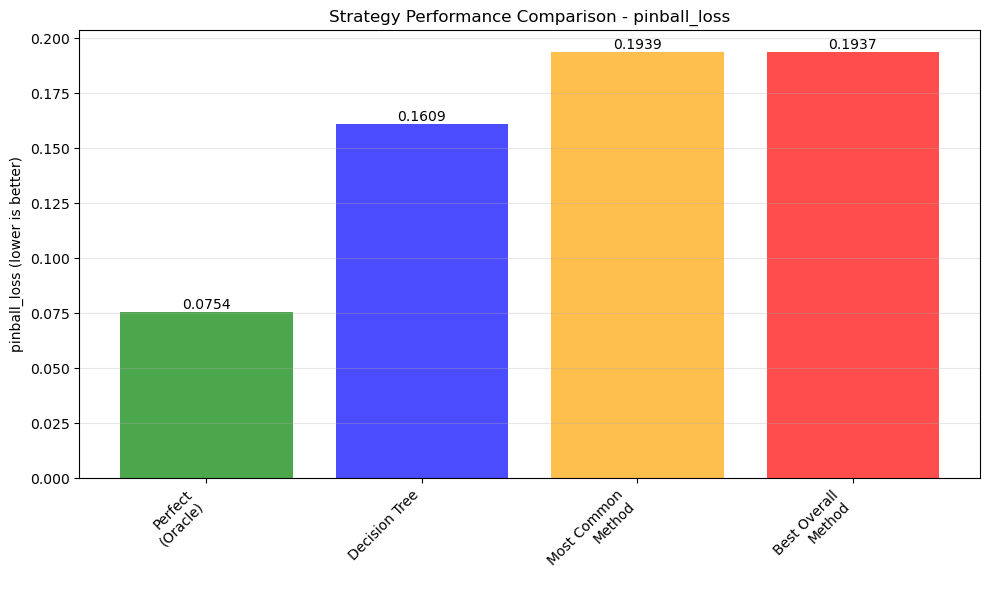

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, matthews_corrcoef, accuracy_score, f1_score
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter

def evaluate_strategy_performance(df, X_test, y_test, y_pred, methods, metric_name="pinball_loss", optimization_direction="minimize"):
    """
    Evaluate different strategy performances for POS method selection.
    
    Parameters:
    - df: Original dataframe with all method performance metrics
    - X_test: Test features
    - y_test: True best methods for test set
    - y_pred: Predicted methods from decision tree
    - methods: List of all available methods
    - metric_name: Name of the metric to evaluate (default: "pinball_loss")
    - optimization_direction: "minimize" or "maximize" for the metric
    
    Returns:
    - Dictionary with strategy performance results
    """
    
    # CREATE METHOD MAPPING HERE - handles any naming mismatches
    method_mapping = {
        'Bayesian': 'Bayesian_POS',  # Add this line to map Bayesian -> Bayesian_POS
        # Add other mappings if needed, e.g.:
        # 'SomeOtherName': 'ActualColumnName'
    }
    
    def map_method_name(method_name):
        """Map method names from best_method column to actual column names."""
        return method_mapping.get(method_name, method_name)
    
    # Get the test set indices to align with original dataframe
    test_indices = X_test.index
    
    # 1. Perfect Strategy (Oracle): Always pick the best method
    perfect_metric_values = []
    for idx in test_indices:
        best_method = df.loc[idx, f'best_method_{metric_name}']
        # APPLY MAPPING HERE
        mapped_method = map_method_name(best_method)
        column_name = f'{mapped_method}_{metric_name}'
        
        # Skip if column doesn't exist or value is NaN
        if column_name not in df.columns:
            continue
        best_metric_value = df.loc[idx, column_name]
        if pd.isna(best_metric_value):
            continue
        perfect_metric_values.append(best_metric_value)
    
    perfect_avg_metric = np.mean(perfect_metric_values) if perfect_metric_values else float('nan')
    
    # 2. Decision Tree Strategy: Use classifier predictions
    dt_metric_values = []
    print(f"\nDEBUG: Decision tree predictions (first 10):")
    for i, idx in enumerate(test_indices):
        predicted_method = y_pred[i]
        # APPLY MAPPING HERE
        mapped_method = map_method_name(predicted_method)
        column_name = f'{mapped_method}_{metric_name}'
        
        # Debug output for first 10 predictions
        if i < 10:
            exists = column_name in df.columns
            value = df.loc[idx, column_name] if exists else "N/A"
            print(f"  {i}: '{predicted_method}' -> '{mapped_method}' -> {column_name} (exists: {exists}, value: {value})")
        
        # Skip if column doesn't exist or value is NaN
        if column_name not in df.columns:
            continue
        predicted_metric_value = df.loc[idx, column_name]
        if pd.isna(predicted_metric_value):
            continue
        dt_metric_values.append(predicted_metric_value)
    
    print(f"Valid decision tree predictions: {len(dt_metric_values)} out of {len(test_indices)}")
    dt_avg_metric = np.mean(dt_metric_values) if dt_metric_values else float('nan')
    
    # 3. Most Common Method Strategy (from training set)
    y_train = df.loc[~df.index.isin(test_indices), f'best_method_{metric_name}']
    most_common_method = y_train.mode()[0]  # Use training set to determine most common
    # APPLY MAPPING HERE
    mapped_most_common = map_method_name(most_common_method)
    common_metric_values = []
    column_name = f'{mapped_most_common}_{metric_name}'
    
    if column_name in df.columns:
        for idx in test_indices:
            common_metric_value = df.loc[idx, column_name]
            if not pd.isna(common_metric_value):
                common_metric_values.append(common_metric_value)
    
    common_avg_metric = np.mean(common_metric_values) if common_metric_values else float('nan')
    
    # 4. Best Overall Method Strategy (best average metric across all data)
    method_avg_metrics = {}
    for method in methods:
        column_name = f'{method}_{metric_name}'
        if column_name in df.columns:
            # Only calculate mean for non-NaN values
            valid_values = df[column_name].dropna()
            if len(valid_values) > 0:
                method_avg_metrics[method] = valid_values.mean()
    
    if method_avg_metrics:
        if optimization_direction == "minimize":
            best_overall_method = min(method_avg_metrics, key=method_avg_metrics.get)
        else:
            best_overall_method = max(method_avg_metrics, key=method_avg_metrics.get)
        
        best_overall_metric_values = []
        column_name = f'{best_overall_method}_{metric_name}'
        for idx in test_indices:
            best_overall_metric_value = df.loc[idx, column_name]
            if not pd.isna(best_overall_metric_value):
                best_overall_metric_values.append(best_overall_metric_value)
        
        best_overall_avg_metric = np.mean(best_overall_metric_values) if best_overall_metric_values else float('nan')
    else:
        best_overall_method = "N/A"
        best_overall_avg_metric = float('nan')
    
    # Calculate performance gaps relative to perfect strategy
    if optimization_direction == "minimize":
        dt_gap = ((dt_avg_metric - perfect_avg_metric) / perfect_avg_metric) * 100
        common_gap = ((common_avg_metric - perfect_avg_metric) / perfect_avg_metric) * 100
        best_overall_gap = ((best_overall_avg_metric - perfect_avg_metric) / perfect_avg_metric) * 100
    else:
        dt_gap = ((perfect_avg_metric - dt_avg_metric) / perfect_avg_metric) * 100
        common_gap = ((perfect_avg_metric - common_avg_metric) / perfect_avg_metric) * 100
        best_overall_gap = ((perfect_avg_metric - best_overall_avg_metric) / perfect_avg_metric) * 100
    
    results = {
        'metric_name': metric_name,
        'optimization_direction': optimization_direction,
        'perfect_strategy': {
            'avg_metric': perfect_avg_metric,
            'description': 'Oracle - always picks the truly best method'
        },
        'decision_tree_strategy': {
            'avg_metric': dt_avg_metric,
            'gap_from_perfect_pct': dt_gap,
            'description': 'Decision tree predictions'
        },
        'most_common_strategy': {
            'avg_metric': common_avg_metric,
            'gap_from_perfect_pct': common_gap,
            'method_used': most_common_method,
            'description': f'Always use most common method ({most_common_method})'
        },
        'best_overall_strategy': {
            'avg_metric': best_overall_avg_metric,
            'gap_from_perfect_pct': best_overall_gap,
            'method_used': best_overall_method,
            'description': f'Always use method with best overall average ({best_overall_method})'
        },
        'method_averages': method_avg_metrics,
        'test_set_size': len(test_indices)
    }
    
    return results

def print_strategy_comparison(results):
    """Print a formatted comparison of strategy performances."""
    
    metric_name = results['metric_name']
    direction = results['optimization_direction']
    
    print(f"\n{'='*60}")
    print(f"STRATEGY PERFORMANCE COMPARISON - {metric_name.upper()}")
    print(f"Optimization Direction: {direction.upper()}")
    print(f"Test Set Size: {results['test_set_size']}")
    print(f"{'='*60}")
    
    strategies = ['perfect_strategy', 'decision_tree_strategy', 'most_common_strategy', 'best_overall_strategy']
    
    for strategy in strategies:
        data = results[strategy]
        print(f"\n{data['description']}:")
        print(f"  Average {metric_name}: {data['avg_metric']:.4f}")
        
        if 'gap_from_perfect_pct' in data:
            gap = data['gap_from_perfect_pct']
            if direction == "minimize":
                print(f"  Performance gap: +{gap:.2f}% worse than perfect")
            else:
                print(f"  Performance gap: -{gap:.2f}% worse than perfect")
        
        if 'method_used' in data:
            print(f"  Method used: {data['method_used']}")
    
    print(f"\n{'='*60}")
    print("METHOD AVERAGES ACROSS ALL DATA:")
    print(f"{'='*60}")
    sorted_methods = sorted(results['method_averages'].items(), 
                          key=lambda x: x[1], 
                          reverse=(direction == "maximize"))
    
    for method, avg_score in sorted_methods:
        print(f"  {method}: {avg_score:.4f}")

def plot_strategy_comparison(results):
    """Create a visualization comparing strategy performances."""
    
    strategies = ['Perfect\n(Oracle)', 'Decision Tree', 'Most Common\nMethod', 'Best Overall\nMethod']
    values = [
        results['perfect_strategy']['avg_metric'],
        results['decision_tree_strategy']['avg_metric'],
        results['most_common_strategy']['avg_metric'],
        results['best_overall_strategy']['avg_metric']
    ]
    
    colors = ['green', 'blue', 'orange', 'red']
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(strategies, values, color=colors, alpha=0.7)
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{value:.4f}', ha='center', va='bottom')
    
    plt.title(f'Strategy Performance Comparison - {results["metric_name"]}')
    plt.ylabel(f'{results["metric_name"]} ({"lower is better" if results["optimization_direction"] == "minimize" else "higher is better"})')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.grid(axis='y', alpha=0.3)
    plt.show()

# Your code adapted to the evaluation framework
def run_complete_evaluation():
    """Run the complete decision tree training and evaluation pipeline for pinball loss."""
    
    # Step 1: set up data for DT
    df = pd.read_csv('dt_inputs/Sales_DT_Input.csv')
    df.drop(['Gesamtzeilen','KSR_Count','TSR_Count','KSR_TSR_Summe'], axis='columns', inplace=True)
    feature_cols = ["KSR_Anteil", "TSR_Anteil", "KSR_TSR_Anteil", "data_sparsity", "laenge",
                    "stockout_rate", "verkauf_variance", "verkauf_mean", "coefficient_of_variation", "unique_quantities", 'variance_to_mean_ratio',
                    "verkauf_autocorr", "adi", "censored_rate", "censored_n"]
    df = df[df['laenge']>1] #so we have variance values for all points

    print(f"{df.isna().any(axis=1).sum()} rows with missing values")
    print(f"{df[feature_cols].isna().any(axis=1).sum()} rows with missing feature values")
    print(f"{df[['Bayesian_POS_pinball_loss']].isna().any(axis=1).sum()} rows with missing Bayesian results")
    print(f"{df[['Agrawal_pinball_loss']].isna().any(axis=1).sum()} rows with missing Agrawal results")
    print(f"{df[['Bayesian_POS_pinball_loss', 'Agrawal_pinball_loss']].isna().any(axis=1).sum()} rows with missing Agrawal or Bayesian results")

    methods = ['N1', 'N2', 'N3', 'EM', 'PD', 'Conrad', 'Nahmias', 'Bayesian_POS', 'Baseline', 'Agrawal']

    X = df[feature_cols]
    y = df['best_method_pinball_loss']
    print("Target distribution:")
    print(y.value_counts())

    # Step 2: Split into train and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    y_counts = Counter(y_train)
    print("\nTraining set distribution:")
    print(y_train.value_counts())

    # Step 3: resample training set
    small_classes = [cls for cls, count in y_counts.items() if count < 6]
    majority_class = max(y_counts, key=y_counts.get)
    random_sampling_strategy = {cls: 6 for cls in small_classes} #for groups with < 6 items, use random sampling to increase size to 6
    under_sampling_strategy = {'Baseline': 6000, 'Conrad': 6000} #use random undersampling on majority class to reduce
    sampler = Pipeline(steps=[
        ('under', RandomUnderSampler(sampling_strategy=under_sampling_strategy, random_state=42)),
        ('random', RandomOverSampler(sampling_strategy=random_sampling_strategy, random_state=42)),
        ('smote', SMOTE(sampling_strategy='auto', random_state=42))
    ])

    X_train_resampled, y_train_resampled = sampler.fit_resample(X_train, y_train)
    print('After resampling:')
    print(y_train_resampled.value_counts())

    # Step 4: hyperparameter tuning
    print("\nHyperparameter tuning:")
    max_depth = [4]
    min_samples_leaf = [1, 20, 40]
    criterion = ['entropy', 'gini', 'log_loss']
    for md in max_depth:
        for c in criterion:
            clf = DecisionTreeClassifier(random_state=42,max_depth=md, criterion=c, min_samples_leaf=1)
            clf.fit(X_train_resampled, y_train_resampled)
            y_pred = clf.predict(X_test)
            acc = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred, average='macro')
            mcc = matthews_corrcoef(y_test, y_pred)

            print(f"max_depth={md}, criterion = {c} "
                f"-> Accuracy: {acc:.4f}, F1 (macro): {f1:.4f}, MCC: {mcc:.4f}")
            
    # Step 5: Train DT on best hyperparameters
    clf = DecisionTreeClassifier(random_state=42,max_depth=10, criterion='gini', min_samples_leaf=1)
    clf.fit(X_train_resampled, y_train_resampled)

    # Evaluate
    y_pred = clf.predict(X_test)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("Matthew's correlation coefficient:", matthews_corrcoef(y_test, y_pred))

    # Step 6: Strategy Performance Evaluation
    print("\n" + "="*80)
    print("STRATEGY PERFORMANCE EVALUATION - PINBALL LOSS")
    print("="*80)
    
    # Evaluate for pinball_loss metric
    results = evaluate_strategy_performance(
        df=df, 
        X_test=X_test, 
        y_test=y_test, 
        y_pred=y_pred, 
        methods=methods,
        metric_name="pinball_loss",
        optimization_direction="minimize"
    )
    
    print_strategy_comparison(results)
    plot_strategy_comparison(results)
    
    return results, clf, X_test, y_test, y_pred

# Run the complete evaluation
if __name__ == "__main__":
    results, trained_model, X_test, y_test, y_pred = run_complete_evaluation()

# No Resampling

7005 rows with missing values
0 rows with missing feature values
5797 rows with missing Bayesian_POS results
5083 rows with missing Agrawal results
5797 rows with missing Agrawal or Bayesian results
Target distribution:
best_method_pinball_loss
Baseline    9191
Conrad      8010
N1           850
Bayesian     809
Nahmias      790
Agrawal      363
EM           152
N2            68
PD             5
N3             2
Name: count, dtype: int64

Training set distribution:
best_method_pinball_loss
Baseline    7353
Conrad      6408
N1           680
Bayesian     647
Nahmias      632
Agrawal      290
EM           122
N2            54
PD             4
N3             2
Name: count, dtype: int64

Hyperparameter tuning (no resampling):
max_depth=4, criterion=entropy -> Accuracy: 0.6314, F1 (macro): 0.1514, MCC: 0.3674
max_depth=4, criterion=gini -> Accuracy: 0.6317, F1 (macro): 0.2052, MCC: 0.3710
max_depth=4, criterion=log_loss -> Accuracy: 0.6314, F1 (macro): 0.1514, MCC: 0.3674

Classification Repo

/opt/anaconda3/envs/tum/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/tum/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/tum/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


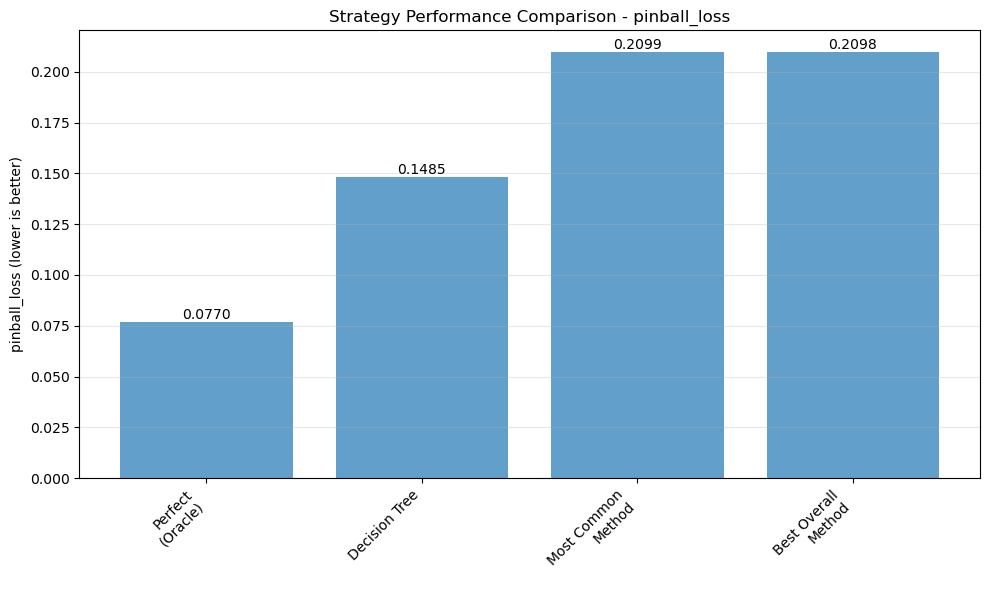

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, matthews_corrcoef
)
from collections import Counter

# ----------------- helpers (unchanged) -----------------
def evaluate_strategy_performance(df, X_test, y_test, y_pred, methods, metric_name="pinball_loss", optimization_direction="minimize"):
    method_mapping = {'Bayesian': 'Bayesian_POS'}
    def map_method_name(method_name): return method_mapping.get(method_name, method_name)
    test_indices = X_test.index

    # Perfect (oracle)
    perfect_metric_values = []
    for idx in test_indices:
        best_method = df.loc[idx, f'best_method_{metric_name}']
        mapped = map_method_name(best_method)
        col = f'{mapped}_{metric_name}'
        if col in df.columns and not pd.isna(df.loc[idx, col]):
            perfect_metric_values.append(df.loc[idx, col])
    perfect_avg = np.mean(perfect_metric_values) if perfect_metric_values else float('nan')

    # Decision tree
    dt_metric_values = []
    for i, idx in enumerate(test_indices):
        mapped = map_method_name(y_pred[i])
        col = f'{mapped}_{metric_name}'
        if col in df.columns and not pd.isna(df.loc[idx, col]):
            dt_metric_values.append(df.loc[idx, col])
    dt_avg = np.mean(dt_metric_values) if dt_metric_values else float('nan')

    # Most common (from training set)
    y_train = df.loc[~df.index.isin(test_indices), f'best_method_{metric_name}']
    most_common_method = y_train.mode()[0]
    mapped_common = map_method_name(most_common_method)
    common_values, col = [], f'{mapped_common}_{metric_name}'
    if col in df.columns:
        for idx in test_indices:
            v = df.loc[idx, col]
            if not pd.isna(v): common_values.append(v)
    common_avg = np.mean(common_values) if common_values else float('nan')

    # Best overall method
    method_avg_metrics = {}
    for m in methods:
        col = f'{m}_{metric_name}'
        if col in df.columns:
            vals = df[col].dropna()
            if len(vals) > 0:
                method_avg_metrics[m] = vals.mean()
    if method_avg_metrics:
        pick = min if optimization_direction == "minimize" else max
        best_overall_method = pick(method_avg_metrics, key=method_avg_metrics.get)
        best_overall_values, col = [], f'{best_overall_method}_{metric_name}'
        for idx in test_indices:
            v = df.loc[idx, col]
            if not pd.isna(v): best_overall_values.append(v)
        best_overall_avg = np.mean(best_overall_values) if best_overall_values else float('nan')
    else:
        best_overall_method, best_overall_avg = "N/A", float('nan')

    # gaps vs oracle
    if optimization_direction == "minimize":
        dt_gap = ((dt_avg - perfect_avg) / perfect_avg) * 100
        common_gap = ((common_avg - perfect_avg) / perfect_avg) * 100
        best_overall_gap = ((best_overall_avg - perfect_avg) / perfect_avg) * 100
    else:
        dt_gap = ((perfect_avg - dt_avg) / perfect_avg) * 100
        common_gap = ((perfect_avg - common_avg) / perfect_avg) * 100
        best_overall_gap = ((perfect_avg - best_overall_avg) / perfect_avg) * 100

    return {
        'metric_name': metric_name,
        'optimization_direction': optimization_direction,
        'perfect_strategy': {'avg_metric': perfect_avg, 'description': 'Oracle - always picks the truly best method'},
        'decision_tree_strategy': {'avg_metric': dt_avg, 'gap_from_perfect_pct': dt_gap, 'description': 'Decision tree predictions'},
        'most_common_strategy': {'avg_metric': common_avg, 'gap_from_perfect_pct': common_gap, 'method_used': most_common_method,
                                 'description': f'Always use most common method ({most_common_method})'},
        'best_overall_strategy': {'avg_metric': best_overall_avg, 'gap_from_perfect_pct': best_overall_gap, 'method_used': best_overall_method,
                                  'description': f'Always use method with best overall average ({best_overall_method})'},
        'method_averages': method_avg_metrics,
        'test_set_size': len(test_indices)
    }

def print_strategy_comparison(results):
    metric_name = results['metric_name']
    direction = results['optimization_direction']
    print(f"\n{'='*60}")
    print(f"STRATEGY PERFORMANCE COMPARISON - {metric_name.upper()}")
    print(f"Optimization Direction: {direction.upper()}")
    print(f"Test Set Size: {results['test_set_size']}")
    print(f"{'='*60}")
    for key in ['perfect_strategy','decision_tree_strategy','most_common_strategy','best_overall_strategy']:
        data = results[key]
        print(f"\n{data['description']}:")
        print(f"  Average {metric_name}: {data['avg_metric']:.4f}")
        if 'gap_from_perfect_pct' in data:
            gap = data['gap_from_perfect_pct']
            if direction == "minimize":
                print(f"  Performance gap: +{gap:.2f}% worse than perfect")
            else:
                print(f"  Performance gap: -{gap:.2f}% worse than perfect")
        if 'method_used' in data:
            print(f"  Method used: {data['method_used']}")
    print(f"\n{'='*60}\nMETHOD AVERAGES ACROSS ALL DATA:\n{'='*60}")
    rev = (direction == "maximize")
    for method, avg in sorted(results['method_averages'].items(), key=lambda x: x[1], reverse=rev):
        print(f"  {method}: {avg:.4f}")

def plot_strategy_comparison(results):
    names = ['Perfect\n(Oracle)', 'Decision Tree', 'Most Common\nMethod', 'Best Overall\nMethod']
    vals = [results['perfect_strategy']['avg_metric'],
            results['decision_tree_strategy']['avg_metric'],
            results['most_common_strategy']['avg_metric'],
            results['best_overall_strategy']['avg_metric']]
    plt.figure(figsize=(10, 6))
    bars = plt.bar(names, vals, alpha=0.7)
    for b, v in zip(bars, vals):
        h = b.get_height()
        plt.text(b.get_x()+b.get_width()/2., h, f'{v:.4f}', ha='center', va='bottom')
    plt.title(f'Strategy Performance Comparison - {results["metric_name"]}')
    better = "lower is better" if results["optimization_direction"] == "minimize" else "higher is better"
    plt.ylabel(f'{results["metric_name"]} ({better})')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.grid(axis='y', alpha=0.3)
    plt.show()

# ----------------- main pipeline (no resampling) -----------------
def run_complete_evaluation():
    """Decision tree without any resampling; plain train/test split."""
    # 1) load & prep
    df = pd.read_csv('dt_inputs/Sales_DT_Input.csv')
    df.drop(['Gesamtzeilen','KSR_Count','TSR_Count','KSR_TSR_Summe'], axis='columns', inplace=True, errors='ignore')

    feature_cols = ["KSR_Anteil", "TSR_Anteil", "KSR_TSR_Anteil", "data_sparsity", "laenge",
                    "stockout_rate", "verkauf_variance", "verkauf_mean", "coefficient_of_variation",
                    "unique_quantities", "variance_to_mean_ratio", "verkauf_autocorr", "adi",
                    "censored_rate", "censored_n"]
    df = df[df['laenge'] > 1]

    print(f"{df.isna().any(axis=1).sum()} rows with missing values")
    print(f"{df[feature_cols].isna().any(axis=1).sum()} rows with missing feature values")
    for col in ['Bayesian_POS_pinball_loss','Agrawal_pinball_loss']:
        if col in df.columns:
            print(f"{df[[col]].isna().any(axis=1).sum()} rows with missing {col.split('_pinball_loss')[0]} results")
    if all(c in df.columns for c in ['Bayesian_POS_pinball_loss','Agrawal_pinball_loss']):
        print(f"{df[['Bayesian_POS_pinball_loss','Agrawal_pinball_loss']].isna().any(axis=1).sum()} rows with missing Agrawal or Bayesian results")

    methods = ['N1','N2','N3','EM','PD','Conrad','Nahmias','Bayesian_POS','Baseline','Agrawal']
    X = df[feature_cols]
    y = df['best_method_pinball_loss']
    print("Target distribution:"); print(y.value_counts())

    # 2) split (optionally stratify on y to preserve class mix)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, random_state=42, stratify=y
    )
    print("\nTraining set distribution:")
    print(y_train.value_counts())

    # 3) quick hyperparam sweep (no resampling)
    print("\nHyperparameter tuning (no resampling):")
    for md in [4]:
        for c in ['entropy','gini','log_loss']:
            clf = DecisionTreeClassifier(random_state=42, max_depth=md, criterion=c, min_samples_leaf=1)
            clf.fit(X_train, y_train)
            y_pred_tmp = clf.predict(X_test)
            acc = accuracy_score(y_test, y_pred_tmp)
            f1 = f1_score(y_test, y_pred_tmp, average='macro')
            mcc = matthews_corrcoef(y_test, y_pred_tmp)
            print(f"max_depth={md}, criterion={c} -> Accuracy: {acc:.4f}, F1 (macro): {f1:.4f}, MCC: {mcc:.4f}")

    # 4) train final DT on chosen params
    clf = DecisionTreeClassifier(random_state=42, max_depth=8, criterion='gini', min_samples_leaf=1)
    clf.fit(X_train, y_train)

    # 5) evaluate classifier
    y_pred = clf.predict(X_test)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("Matthew's correlation coefficient:", matthews_corrcoef(y_test, y_pred))

    # 6) strategy performance (pinball loss)
    print("\n" + "="*80)
    print("STRATEGY PERFORMANCE EVALUATION - PINBALL LOSS")
    print("="*80)

    results = evaluate_strategy_performance(
        df=df,
        X_test=X_test,
        y_test=y_test,
        y_pred=y_pred,
        methods=methods,
        metric_name="pinball_loss",
        optimization_direction="minimize"
    )
    print_strategy_comparison(results)
    plot_strategy_comparison(results)

    return results, clf, X_test, y_test, y_pred

if __name__ == "__main__":
    results, trained_model, X_test, y_test, y_pred = run_complete_evaluation()


In [55]:
import pandas as pd

# Change this to 'A', 'E', or 'I'
target_magazine = 'A'

# Read CSV and filter for target magazine
df = pd.read_csv("dt_inputs/Sales_DT_Input.csv")
data = df[df['Magazine'].str.contains(target_magazine, case=False)]

print(f"Found {len(data)} rows for magazine {target_magazine}")

# Methods and KPIs - using UPPERCASE to match your data
methods = ['N1', 'N2', 'N3', 'EM', 'PD', 'Conrad', 'Nahmias', 'Bayesian_POS', 'Baseline', 'Agrawal']
kpis = ['pinball_loss', 'avg_oos_rate', 'avg_beta_fill_rate', 'avg_alpha_service_level']

# Calculate averages
results = pd.DataFrame(index=methods, columns=kpis)

for method in methods:
    for kpi in kpis:
        col = f"{method}_{kpi}"
        if col in data.columns:
            results.loc[method, kpi] = round(data[col].mean(), 3)

print("\nResults:")
print("=" * 50)
print(results.fillna(''))

Found 2951 rows for magazine A

Results:
              pinball_loss  avg_oos_rate  avg_beta_fill_rate  \
N1                   0.218         0.036               0.989   
N2                   0.218         0.036               0.989   
N3                   0.219         0.028               0.993   
EM                   0.226         0.022               0.994   
PD                   0.220         0.028               0.993   
Conrad               0.312         0.025               0.989   
Nahmias              0.309         0.030               0.987   
Bayesian_POS         0.357         0.013               0.991   
Baseline             0.219         0.028               0.992   
Agrawal              0.325         0.022               0.983   

              avg_alpha_service_level  
N1                              0.964  
N2                              0.964  
N3                              0.972  
EM                              0.978  
PD                              0.972  
Conrad        

/var/folders/0t/sl6vwzpd14s39rmw1_tt50nh0000gn/T/ipykernel_83698/3148011530.py:27: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  print(results.fillna(''))


In [46]:
def sales_KPI(df, method_name, c_ratio):
    '''
    Calculate KPIs for sales evaluation using quantity suggested by method
    Parameters:
    - df: pandas DataFrame indexed by date, must have columns: '(Method Name)_Q' (predicted) and 'Verkauf_MBR' (ground truth)
    - method_name: string name of the method being evaluated

    Output:
    OOS rate, alpha service level, beta rate, lost sales, and pinball_loss over all rows
    '''
    def pinball_loss_calculator(row):
        if row['Verkauf_MBR'] >= row[method_name+'_Q']: return c_ratio*(row['Verkauf_MBR']-row[method_name+'_Q'])
        else: return (1-c_ratio)*(-row['Verkauf_MBR']+row[method_name+'_Q'])

    df['avg_oos_rate'] = df['Verkauf_MBR']>df[method_name+"_Q"]
    df['avg_beta_fill_rate'] = df.apply(lambda row: min(row['Verkauf_MBR'], row[method_name+"_Q"])/row['Verkauf_MBR'] if row['Verkauf_MBR']!=0 else None, axis=1)
    df['lost_sales'] = df.apply(lambda row: np.abs(row['Verkauf_MBR']-row[method_name+'_Q']), axis=1)
    df['pinball_loss'] = df.apply(pinball_loss_calculator, axis=1)

    OOS_rate = df['avg_oos_rate'].mean()
    alpha_level = 1 - OOS_rate
    beta_rate = df['avg_beta_fill_rate'].mean()
    lost_sales = df['lost_sales'].sum()
    pinball_loss = df['pinball_loss'].mean()
    
    return {
        method_name + '_avg_oos_rate' : OOS_rate,
        method_name + '_avg_beta_fill_rate': beta_rate,
        method_name + '_avg_alpha_service_level' : alpha_level,
        method_name + '_lost_sales': lost_sales,
        method_name + '_pinball_loss': pinball_loss
    }

def sales_KPI_POS(df, method_name, c_ratio):
    ''''
    Calculate sales KPIs grouped by POS.
    Returns dataframe indexed by POS with KPI values and prints KPIs averaged across all POS
    '''
    df=df.dropna(subset=['Verkauf', 'Bezug']) #didn't run with this yet. Using this instead of df.dropna() will just keep the POS even if method has no Q value
    
    KPIs = []
    for pos, group in df.groupby('EHASTRA_EH_NUMMER'):
        #do not calculate KPI for POS with less than 3 uncensored points
        #if len(group[group['Zensiert']==1])<3: continue
        pos_result = sales_KPI(group, method_name, c_ratio)

        pos_result['EHASTRA_EH_NUMMER'] = pos #add POS to output dictionary
        KPIs.append(pos_result)

    df_KPI_pos = pd.DataFrame(data = KPIs)
    df_KPI_pos = df_KPI_pos.set_index('EHASTRA_EH_NUMMER')

    #print final averaged results
    print("KPIs by POS, averaged over all POS")
    for col in df_KPI_pos.columns:
        print(f'{col}: {df_KPI_pos[col].mean():.3f}')
    return df_KPI_pos

In [ ]:
# For decision tree, calculate sales KPI by POS
# Do NOT drop POS with < 3 censored points
method_name = ''
for letter in 'AEI':
    print(letter)
    df = pd.read_csv('result_files/'+letter+f'_20250212_ZQ0.35_ZG0.4_testfile_{method_name}_Inventory.csv')
    df = df[df['Heftjahr']==2024]
    df_sales_kpi = sales_KPI_POS(df, method_name, 0.9)
    #print(f'{len(df_sales_kpi)} pos')
    #df_sales_kpi.to_csv(letter+f'_20250212_ZQ0.35_ZG0.4_testfile_{method_name}_KPI_sales.csv')

A


FileNotFoundError: [Errno 2] No such file or directory: 'result_files/A_20250212_ZQ0.35_ZG0.4_testfile_Agrawal_Inventory.csv'